In [18]:
import matplotlib.pyplot as plt
import sys
import numpy as np
import network_module as nm
import argparse

def print_csv(filename, data):
    with open(filename, 'wb') as out:
        for t in data:
            out.write('{}\t{}\n'.format(*t))


# layer_params = sys.argv[1:]

# netname = 'mnist-fc-784-'
# for width in layer_params:
#     netname += '{}-'.format(width)
# netname += '10'
reg = 0
L1 = False
L2 = False
L05 = False
netname = 'conv5-3x3-maxpool-100'
data_source = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
def loadcifar():
    import cPickle
    import os.path

    if not os.path.exists('./cifar-10-batches-py/data_batch_1'):
        print 'Downloading train data from', data_source
        import urllib
        import tarfile
        if not os.path.exists('./cifar-10-batches-py/'):
            os.makedirs('./cifar-10-batches-py/')
            
        dest = "./cifar-10-batches-py/data.tar.gz"
        urllib.urlretrieve(data_source, dest)
        print 'unzipping train data'
        tar = tarfile.open(dest, "r:gz")
        tar.extractall()
        tar.close()
    
    
    # Load the dataset
    f = open('./cifar-10-batches-py/data_batch_1', 'rb')
    train = cPickle.load(f)
    f.close()
    train_data = train['data'].reshape(-1,3,32,32).astype(float)
    train_data /= 255.
    label = np.array(train['labels'])
    train_onehot = np.zeros((label.size, label.max() + 1))
    train_onehot[np.arange(label.size), label] = 1

    f = open('./cifar-10-batches-py/test_batch', 'rb')
    test = cPickle.load(f)
    f.close()
    test_data = test['data'][:1000].reshape(-1,3,32,32).astype(float)
    test_data /= 255.
    label = np.array(test['labels'])
    test_onehot = np.zeros((label.size, label.max() + 1))
    test_onehot[np.arange(label.size), label] = 1


    return [(train_data, train_onehot), (test_data, test_onehot)]


# print 'Loading MNIST images...'
# train, test = loadcifar()

train = (np.zeros((50, 1, 20, 20)), np.zeros((50 ,1 ,8 , 8)))
train[0][0,:,5,5] = 0.5
train[1][0,:,4,4] = 1

print 'Constructing network...'
#########################
# NETWORK DEFINITION
nn = nm.network(in_shape=train[0][0].shape, criterion='MSE')
nn.add_conv(10, (5, 5))
#########################
print nn

result = []


def print_test():
    print ' --- Epoch: ', 1, ' error: ',\
          nn.output.get_crit(train[0][0:16], train[1][0:16]).mean()

print 'Working with network', netname


def train_net():
    nn.SGD(train_policy=nn.fix_epoch,
           training_set=train,
           batch=128, rate=0.05, epoch_call_back=print_test, epoch=10)
    print 'Saving results to {}.res'.format(netname)
    print_csv('./results/{}.res'.format(netname), result)

    print 'Saving network snapshot to {}.net'.format(netname)
    nn.save_state('./nets/' + netname + '.net')



def loadnetwork(network_source):
    global nn
    nn = nm.load(network_source)

    
def imshow(im, cmap='Greys_r', interpol='None'):

    if len(im.shape) == 3:
        for i, x in enumerate(im, 1):
            plt.subplot(1, len(im), i)
            plt.imshow(x.squeeze(), cmap=cmap, interpolation=interpol)
            plt.gca().xaxis.set_major_locator(plt.NullLocator())
    if len(im.shape) == 4:
        for irow, xrow in enumerate(im, 0):
            for icol, x in enumerate(xrow, 1):
                print '\r  ', len(im), len(xrow), irow * len(xrow) + icol
                plt.subplot(len(im), len(xrow), irow * len(xrow) + icol)
                plt.imshow(x.squeeze(), cmap=cmap, interpolation=interpol)
                plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.show()
    return im.shape


def visualise_layer(lay_ind=4, top=9, iterations=1000):
    test = nn.grad_ascent(lay_ind, train[0], top, iterations)\
             .reshape((top,) + nn[lay_ind].shape + (28, 28))
    test = np.concatenate((test, test.mean(axis=0)[np.newaxis, :]), axis=0)
    return test


def max_act(lay_ind, top=9):
    return test[0][nn.max_act(lay_ind, test[0], top)].squeeze()



Constructing network...
Network ID: 140279669182800
Network layout:
------------------------------
	INPUT  (1, 20, 20)
	   |
	   |
	  |1|
  convolution  (10, 16, 16)   ->   kernels: (1, 10, 5, 5)
	   |
	   |
	  |2|
  	OUTPUT  (10, 16, 16)   ->   CRITERION  (MSE)
------------------------------
Working with network conv5-3x3-maxpool-100


(10,)
   2 1 1
   2 1 2


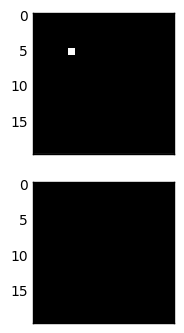

(2, 1, 20, 20)

In [19]:
print nn[1].bias.shape
imshow(train[0][:2])



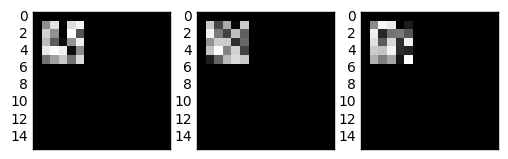

(3, 16, 16)

In [23]:
imshow(nn.get_output(train[0][:1])[0,:3])
# imshow(nn[1].kernels)

In [24]:
nn.SGD(train_policy=nn.fix_epoch, training_set=train, batch=1, rate=0.01, epoch=3, epoch_call_back=print_test())


 --- Epoch:  1  error: 

ValueError: operands could not be broadcast together with shapes (16,10,16,16) (16,1,8,8) 

In [13]:
nn[1].bias.shape

(1,)

In [53]:
np.arange(2*4*3*3).reshape(2,4,3,3)[0].transpose(1,2,0)

array([[[ 0,  9, 18, 27],
        [ 1, 10, 19, 28],
        [ 2, 11, 20, 29]],

       [[ 3, 12, 21, 30],
        [ 4, 13, 22, 31],
        [ 5, 14, 23, 32]],

       [[ 6, 15, 24, 33],
        [ 7, 16, 25, 34],
        [ 8, 17, 26, 35]]])